# Example for Image Classification

This notebook demonstrates how deep learning algorithms classify cancer images using the Breast Cancer Histopathological Image Classification ([BreakHis](https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/)), composed of 9,109 microscopic images of breast tumor tissue collected from 82 patients using different magnifying factors (40X, 100X, 200X, and 400X).

## Step1: Import libraries

The selected framework in this example is [Pytorch](https://pytorch.org/), for this reason we import its components and set the datetime module.

In [2]:
#Import Libraries
import torch
from PIL import Image
import os
import time
from datetime import datetime
from pytz import timezone  
import copy
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
my_timezone = timezone('Chile/Continental')

#Training on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("selected: ",device)

selected:  cuda


## Step2: Data

The dataset is split into two parts, training and validation.

In [3]:
#Download data from Drive as a zip file
!gdown https://drive.google.com/uc?id=1VqZJRgkytim5xDpBR92diKFk85Y-hL0g

Downloading...
From: https://drive.google.com/uc?id=1VqZJRgkytim5xDpBR92diKFk85Y-hL0g
To: /content/breastCancer_images.zip
4.28GB [01:17, 55.2MB/s]


In [4]:
#Unzip the data
!rm -rf breastCancer_images breastCancer_images || true
!unzip -qq breastCancer_images.zip
!rm breastCancer_images.zip || true
folder = 'breastCancer_images/'

## Step 3: Transformation and normalization of the data

Here we convert the images to a Pytorch tensor and we normalizing them using the [TORCHVISION.TRANSFORMS](https://pytorch.org/docs/stable/torchvision/transforms.html) module.

In [5]:
#Transformation for train and valid images
transforms = {'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
}

#Pytorch uses object called DataLoaders to feed data into models. 
image_datasets = {x: datasets.ImageFolder(os.path.join(folder, x), transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

## Step 4: Display data as an image in a grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


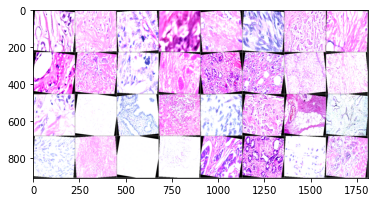

In [6]:
#Plot images from train folder in a grid
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

inputs, classes = next(iter(dataloaders['train'])) #get a batch from training data
out = torchvision.utils.make_grid(inputs) #make grid from  previous data
matplotlib_imshow(out) #plot the grid

## Step 5: Build the model

In [7]:
#Function to train the classifier and save the best model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{} at {}'.format(epoch, num_epochs - 1, datetime.now(my_timezone).strftime('%I:%M:%S %p (%d %b %Y)')))
        print('-' * 10)

        #Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #Iterate
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #Zero out the parameter gradients
                optimizer.zero_grad()

                #Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #Tell the optimizer to calculate the gradient of the loss function and update the model's weight
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
            #Compute accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            #Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
#Measure the trained model's performance and time 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #Load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Step 6: Visualize the model

In [8]:
#Function to visualize the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                matplotlib_imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Train with different pretrained architectures

In [24]:
#Model architectures for image classification
model = models.densenet121(pretrained=True)
#model = models.resnet18(pretrained=True)
#model = models.googlenet(pretrained=True)
#model = models.shufflenet_v2_x1_0(pretrained=True)

for param in model.parameters():
  param.requires_grad = True

#The size of each output sample is set to 2
#It is generalized to (number of features, 2)
model.classifier = nn.Linear(1024, 2)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


### Train with different parameters:

In [25]:
#Selecting a loss function
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()

#Selecting an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

#Decay LR
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [26]:
#Train and evaluate
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9 at 04:26:25 PM (26 Aug 2020)
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2894 Acc: 0.8837
valid Loss: 0.2357 Acc: 0.9015
Epoch 1/9 at 04:29:38 PM (26 Aug 2020)
----------
train Loss: 0.1333 Acc: 0.9467
valid Loss: 0.3072 Acc: 0.8664
Epoch 2/9 at 04:32:52 PM (26 Aug 2020)
----------
train Loss: 0.0837 Acc: 0.9723
valid Loss: 0.2722 Acc: 0.8926
Epoch 3/9 at 04:36:06 PM (26 Aug 2020)
----------
train Loss: 0.0804 Acc: 0.9707
valid Loss: 0.2750 Acc: 0.8887
Epoch 4/9 at 04:39:19 PM (26 Aug 2020)
----------
train Loss: 0.0772 Acc: 0.9740
valid Loss: 0.2731 Acc: 0.8939
Epoch 5/9 at 04:42:36 PM (26 Aug 2020)
----------
train Loss: 0.0721 Acc: 0.9767
valid Loss: 0.2776 Acc: 0.8913
Epoch 6/9 at 04:45:52 PM (26 Aug 2020)
----------
train Loss: 0.0652 Acc: 0.9768
valid Loss: 0.2688 Acc: 0.8977
Epoch 7/9 at 04:49:08 PM (26 Aug 2020)
----------
train Loss: 0.0693 Acc: 0.9765
valid Loss: 0.2712 Acc: 0.8951
Epoch 8/9 at 04:52:25 PM (26 Aug 2020)
----------
train Loss: 0.0675 Acc: 0.9771
valid Loss: 0.2881 Acc: 0.8894
Epoch 9/9 at 04:55:42 PM (26 Aug 2020)
---

### Visualize predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


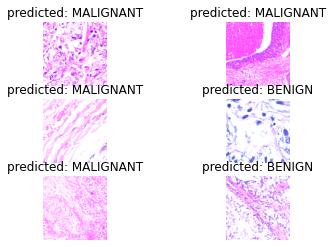

In [11]:
#Visualizing the model predictions
visualize_model(model)